# Imports librays

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
tfds.disable_progress_bar()

In [ ]:
import logging
logger= tf.get_logger()
logger.setLevel(logging.ERROR)

# Download the Flowers Dataset using TensorFlow Datasets

In [ ]:
(tranning_set, validation_set), dataset_info= tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[70%:]"],
    with_info= True,
    as_supervised= True,
)

# Information about the Flowers Dataset

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [ ]:
num_classes= dataset_info.features["label"].num_classes
total_train= 0
total_validation= 0

for i in tranning_set:
  total_train += 1

for i in validation_set:
  total_validation += 1

print("total number of class: {}" .format(num_classes))
print("total number of training images: {}" .format(total_train))
print("total number of validation images: {}" .format(total_validation))

total number of class: 5
total number of training images: 2569
total number of validation images: 1101


check same size or **not**

In [ ]:
for i, example in enumerate(tranning_set.take(10)):
  print("image {} shape: {} label: {}" .format(i+1, example[0].shape, example[1]))

image 1 shape: (333, 500, 3) label: 2
image 2 shape: (212, 320, 3) label: 3
image 3 shape: (240, 320, 3) label: 3
image 4 shape: (240, 320, 3) label: 4
image 5 shape: (317, 500, 3) label: 3
image 6 shape: (212, 320, 3) label: 0
image 7 shape: (240, 240, 3) label: 0
image 8 shape: (333, 500, 3) label: 0
image 9 shape: (240, 320, 3) label: 0
image 10 shape: (240, 320, 3) label: 1


# Reformate and Create Batches

In [ ]:
IMG_SIZE= 224
BATCH_SIZE= 32

def format_img(image, label):
  image= tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0
  return image, label

train_batches= tranning_set.shuffle(total_train//4).map(format_img).batch(BATCH_SIZE).prefetch(1)
validation_batches= validation_set.map(format_img).batch(BATCH_SIZE).prefetch(1)

# Simple Transfer Learning with TensorFlow Hub

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor= hub.KerasLayer(URL,
                                  input_shape= (IMG_SIZE, IMG_SIZE, 3))

Freeze the Pre-Trained Model

In [ ]:
feature_extractor.trainable= False

Attach a classification head

In [ ]:
model= tf.keras.Sequential(
    [
        feature_extractor,
        layers.Dense(num_classes)
    ]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


compile the model

In [ ]:
model.compile(
    optimizer= "adam",
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
    metrics= ["accuracy"]
)

Train the model

In [ ]:
EPOCHS= 5
history= model.fit(
    train_batches,
    epochs= EPOCHS,
    validation_data= validation_batches
)

Epoch 1/5
81/81 [==============================] - 218s 3s/step - loss: 0.7444 - accuracy: 0.7213 - val_loss: 0.4480 - val_accuracy: 0.8429
Epoch 2/5
81/81 [==============================] - 190s 2s/step - loss: 0.3792 - accuracy: 0.8739 - val_loss: 0.3584 - val_accuracy: 0.8692
Epoch 3/5
81/81 [==============================] - 190s 2s/step - loss: 0.2960 - accuracy: 0.8996 - val_loss: 0.3244 - val_accuracy: 0.8847
Epoch 4/5
81/81 [==============================] - 187s 2s/step - loss: 0.2495 - accuracy: 0.9221 - val_loss: 0.3173 - val_accuracy: 0.8874
Epoch 5/5
81/81 [==============================] - 186s 2s/step - loss: 0.2139 - accuracy: 0.9381 - val_loss: 0.2930 - val_accuracy: 0.9010


Plot Training and Validation Graphs

In [ ]:
range(EPOCHS)

range(0, 5)

train and validation accuracy visualigation

Text(0.5, 1.0, 'tranning and validation accuracy')

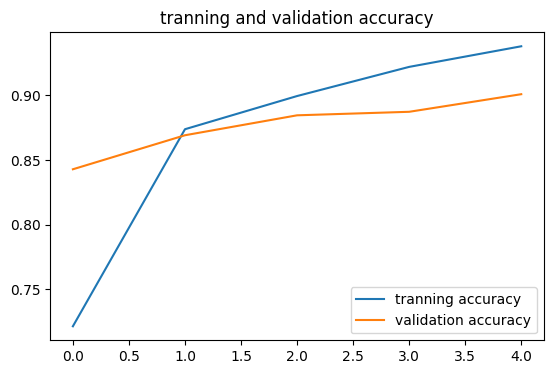

In [ ]:
acc= history.history["accuracy"]
val_acc= history.history["val_accuracy"]
loss= history.history["loss"]
val_loss= history.history["val_loss"]

epoch_range= range(EPOCHS)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, label= "tranning accuracy")
plt.plot(epoch_range, val_acc, label="validation accuracy")
plt.legend(loc= "lower right")
plt.title("tranning and validation accuracy")

tranning and validation loss

Text(0.5, 1.0, 'tranning and validation loss')

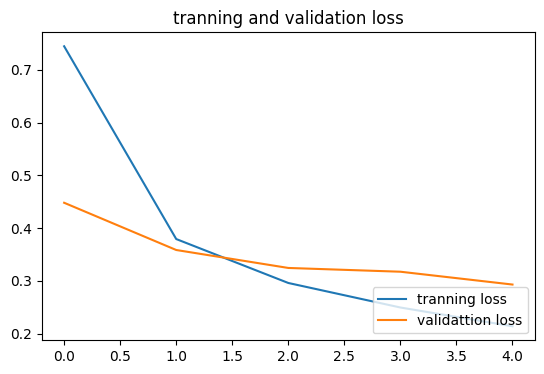

In [ ]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, loss, label= "tranning loss")
plt.plot(epoch_range, val_loss, label="validattion loss")
plt.legend(loc= "lower right")
plt.title("tranning and validation loss")

## Let's some predicrion

In [ ]:
class_name= np.array(dataset_info.features["label"].names)
print(class_name)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


to create a image batch and make predictions

In [ ]:
image_batch, label_batch= next(iter(train_batches))
image_batch= image_batch.numpy()
label_batch= label_batch.numpy()

predict_batch= model.predict(image_batch)
predict_batch= tf.squeeze(predict_batch).numpy()
predicted= np.argmax(predict_batch, axis=-1)
predicted_class_name= class_name[predicted]
print(predicted_class_name)

1/1 [==============================] - 2s 2s/step
['tulips' 'daisy' 'tulips' 'roses' 'dandelion' 'daisy' 'dandelion'
 'sunflowers' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'dandelion'
 'roses' 'tulips' 'tulips' 'dandelion' 'dandelion' 'daisy' 'roses'
 'sunflowers' 'dandelion' 'roses' 'dandelion' 'daisy' 'sunflowers'
 'dandelion' 'dandelion' 'dandelion' 'tulips' 'tulips' 'sunflowers']


print true class labels

In [ ]:
print("labels: ", label_batch)
print("predicted labels: ", predicted)

labels:  [2 1 2 4 0 1 0 3 3 4 3 0 0 4 2 2 0 0 1 4 3 0 4 0 1 3 0 0 0 2 2 3]
predicted labels:  [2 1 2 4 0 1 0 3 3 4 3 0 0 4 2 2 0 0 1 4 3 0 4 0 1 3 0 0 0 2 2 3]


plot model predicttions

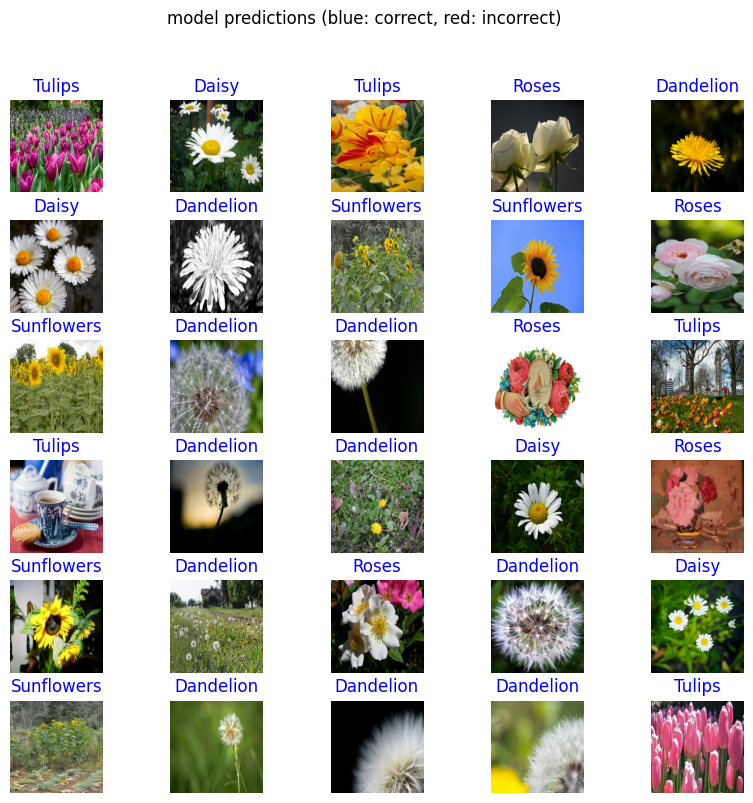

In [ ]:
plt.figure(figsize= (10, 9))
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.subplots_adjust(hspace= 0.3)
  plt.imshow(image_batch[n])
  color= "blue" if predicted[n]== label_batch[n] else "red"
  plt.title(predicted_class_name[n].title(), color= color)
  plt.axis("off")
  _ = plt.suptitle("model predictions (blue: correct, red: incorrect)")

# Perform Transfer Learning with the Inception Model

In [ ]:
# IMG_SIZE = 299

# (training_set, validation_set), dataset_info = tfds.load(
#     'tf_flowers',
#     with_info=True,
#     as_supervised=True,
#     split=['train[:70%]', 'train[70%:]'],
# )
# train_batches = training_set.shuffle(total_train//4).map(format_img).batch(BATCH_SIZE).prefetch(1)
# validation_batches = validation_set.map(format_img).batch(BATCH_SIZE).prefetch(1)

# URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
# feature_extractor = hub.KerasLayer(URL,
#   input_shape=(IMG_SIZE, IMG_SIZE, 3),
#   trainable=False)

# model_inception = tf.keras.Sequential([
#   feature_extractor,
#   tf.keras.layers.Dense(num_classes)
# ])

# model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# model_inception.compile(
#   optimizer='adam',
#   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#   metrics=['accuracy'])

# EPOCHS = 5

# history = model_inception.fit(train_batches,
#                     epochs=EPOCHS,
#                     validation_data=validation_batches)

Epoch 1/5
81/81 [==============================] - 976s 12s/step - loss: 0.7284 - accuracy: 0.7559 - val_loss: 0.4324 - val_accuracy: 0.8683
Epoch 2/5
81/81 [==============================] - 956s 12s/step - loss: 0.3770 - accuracy: 0.8809 - val_loss: 0.3499 - val_accuracy: 0.8965
Epoch 3/5
81/81 [==============================] - 956s 12s/step - loss: 0.3021 - accuracy: 0.9089 - val_loss: 0.3153 - val_accuracy: 0.8955
Epoch 4/5
81/81 [==============================] - 960s 12s/step - loss: 0.2539 - accuracy: 0.9260 - val_loss: 0.2935 - val_accuracy: 0.9037
Epoch 5/5
81/81 [==============================] - 959s 12s/step - loss: 0.2262 - accuracy: 0.9334 - val_loss: 0.2804 - val_accuracy: 0.9019


# Saving and loading models
In this part, i will learn how to **save a train model** for farther use. I saving this model in **HDF5 format** for Keras, then saving models in the **tensorflow SaveModel** formate, then **Loading the models**, at last I **download models** to Local Disk.

In [ ]:
import time
# Generate a unique export path based on the current timestamp
t = int(time.time())
export_path_save_model = "./{}".format(t)

# Save your Keras model using model.save
model.save(export_path_save_model)

In [ ]:
# Load the model using tf.keras.models.load_model
reload_save_model_keras = tf.keras.models.load_model(
    export_path_save_model,
    custom_objects={"KerasLayer": hub.KerasLayer}
)

In [ ]:
reload_save_model_keras.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
result_batch= model.predict(image_batch)
reload_save_model_keras_batch= reload_save_model_keras.predict(image_batch)

1/1 [==============================] - 2s 2s/step


We can check that the reloaded Keras model and the previous model give the same result.


In [ ]:
(abs(result_batch- reload_save_model_keras_batch)).max()

0.0

# Download the model

In [ ]:

!zip -r model.zip {export_path_save_model}


  adding: 1694108857/ (stored 0%)
  adding: 1694108857/saved_model.pb (deflated 91%)
  adding: 1694108857/keras_metadata.pb (deflated 80%)
  adding: 1694108857/fingerprint.pb (stored 0%)
  adding: 1694108857/assets/ (stored 0%)
  adding: 1694108857/variables/ (stored 0%)
  adding: 1694108857/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: 1694108857/variables/variables.index (deflated 78%)


The zip file is saved in the current working directory. You can see what the current working directory is by running:

In [ ]:
!ls

1694108104  1694108857	model.zip  sample_data


Once the file is zipped, you can download it to your local disk.

In [ ]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>